In [36]:
#| 模型              | Test Accuracy                      |
# | 前半凍結後半finetune50%--------------------------------------------------| 
# | MobileNetV2       | 0.8833333333333333                 |
# | EfficientNetB0    | 0.9305555555555556                 |
# | EfficientNetB1    | 0.9277777777777778                 |
# | EfficientNetV2S   | 0.9166666666666666                 |
# | EfficientNetV2M   | 0.9388888888888889                 |
# | ConvNeXtTiny      |                 |

In [37]:
# %% [code]
# Test Accuracy 比較
# 
# | 模型              | Test Accuracy                      |
# | 全凍結--------------------------------------------------| 
# | MobileNetV2       | 0.8361344537815126                 |
# | EfficientNetB0    | 0.8403361344537815                 |
# | EfficientNetB1    | 0.8403361344537815                 |
# | EfficientNetV2S   | 0.7815126050420168                 |
# | EfficientNetV2M   | 0.7415966386554622                 |
# | ConvNeXtTiny      | 0.8382352941176471                 |
# | 全訓練--------------------------------------------------|
# | MobileNetV2       | 0.8466386554621849                 |
# | EfficientNetB0    | 0.8634453781512605                 |
# | EfficientNetB1    | 0.8718487394957983                 |
# | EfficientNetV2S   | 0.8298319327731093                 |
# | EfficientNetV2M   | 0.8172268907563025                 |
# | ConvNeXtTiny      | 0.7815126050420168                 |


import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torchvision
from torchvision import transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from pathlib import Path
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import random
from torch.backends import cudnn

In [38]:
# 檢查 GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# 固定隨機種子
SEED = 1
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
cudnn.deterministic = True
cudnn.benchmark = False

# 如果要 DataLoader worker 也固定種子
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 建議在你的 DataLoader 中這樣使用：
g = torch.Generator()
g.manual_seed(SEED)

Using device: cuda


In [39]:
INPUT_PATH = '/kaggle/input/realwasted/archive/realwaste-main/RealWaste'
print(os.listdir(INPUT_PATH))

# 資料載入
all_classes = ['Glass', 'Metal', 'Food Organics', 'Miscellaneous Trash', 'Plastic',
               'Paper', 'Textile Trash', 'Cardboard', 'Vegetation']



['Metal', 'Glass', 'Paper', 'Vegetation', 'Cardboard', 'Textile Trash', 'Food Organics', 'Plastic', 'Miscellaneous Trash']


In [40]:
def load_data():
    data = []
    for idx, cls in enumerate(all_classes):
        images = Path(f"{INPUT_PATH}/{cls}").glob("*.jpg")
        data.extend([(img, idx) for img in images])
    return pd.DataFrame(data, columns=['image', 'label'])

total_data = load_data()
train_val_df, test_df = train_test_split(total_data, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=3/17, random_state=42)

In [41]:
label_counts = test_df['label'].value_counts()
assert all(label_counts >= 40), "有類別樣本數不足 40！"

In [42]:
test_df = test_df.groupby('label').sample(n=40, random_state=42).reset_index(drop=True)

In [43]:
train_df = train_df.sample(frac=1., random_state=100).reset_index(drop=True)

In [44]:
# Dataset 定義
class WasteDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = str(self.data.iloc[idx]['image'])
        label = self.data.iloc[idx]['label']
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [45]:
train_dataset = WasteDataset(train_df, transform=transform)
val_dataset = WasteDataset(val_df, transform=transform)
test_dataset = WasteDataset(test_df, transform=transform)

x_train = DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g)
x_val = DataLoader(val_dataset, batch_size=16, shuffle=False, worker_init_fn=seed_worker, generator=g)
x_test = DataLoader(test_dataset, batch_size=16, shuffle=False, worker_init_fn=seed_worker, generator=g)

In [46]:
"""model = models.mobilenet_v2(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 9)
model = model.to(device)
model_dir = f"./models/MobileNetV2"""



"""
model = models.efficientnet_b0(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 9)
model = model.to(device)
model_dir = f"./models/EfficientNetB0"
"""

"""
model = models.efficientnet_b1(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 9)
model = model.to(device)
model_dir = f"./models/EfficientNetB1"
"""


"""
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 9)
model = model.to(device)
model_dir = f"./models/EfficientNetV2S"
"""


model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 9)
model = model.to(device)
model_dir = f"./models/EfficientNetV2M"


"""
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 9)
model = model.to(device)
model_dir = f"./models/ConvNeXtTiny"
"""



Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:00<00:00, 226MB/s] 


'\nmodel = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)\nin_features = model.classifier[2].in_features\nmodel.classifier[2] = nn.Linear(in_features, 9)\nmodel = model.to(device)\nmodel_dir = f"./models/ConvNeXtTiny"\n'

In [47]:
"""全凍結"""
for param in model.features.parameters():
    param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

best_val_acc = 0.0
initial_epochs = 100
freeze_epochs = 50

train_acc_list = []
val_acc_list = []



In [48]:
# 訓練與驗證迴圈
for epoch in range(initial_epochs):
    if epoch == freeze_epochs:
        print(f"🔓 解凍一半層數進行 fine-tuning at epoch {epoch}")

        total_layers = list(model.named_parameters())
        num_to_unfreeze = len(total_layers) // 2

        for name, param in total_layers[-num_to_unfreeze:]:
            param.requires_grad = True

        # 🔁 重新建立 optimizer（必須）
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(x_train):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in x_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # 根據模型名稱建立資料夾並儲存
        os.makedirs(model_dir, exist_ok=True)
        model_path = os.path.join(model_dir, "best_model.pth")
        torch.save(model.state_dict(), model_path)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    #scheduler.step()
    
    print(f"Epoch {epoch+1}/{initial_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")




100%|██████████| 208/208 [00:34<00:00,  6.06it/s]


Epoch 1/100 - Loss: 327.0583, Train Acc: 0.4838, Val Acc: 0.6311


100%|██████████| 208/208 [00:33<00:00,  6.26it/s]


Epoch 2/100 - Loss: 238.0753, Train Acc: 0.6287, Val Acc: 0.6774


100%|██████████| 208/208 [00:31<00:00,  6.55it/s]


Epoch 3/100 - Loss: 210.8341, Train Acc: 0.6693, Val Acc: 0.6802


100%|██████████| 208/208 [00:38<00:00,  5.38it/s]


Epoch 4/100 - Loss: 199.8616, Train Acc: 0.6729, Val Acc: 0.6830


100%|██████████| 208/208 [00:34<00:00,  5.97it/s]


Epoch 5/100 - Loss: 192.5175, Train Acc: 0.6891, Val Acc: 0.6957


100%|██████████| 208/208 [00:31<00:00,  6.61it/s]


Epoch 6/100 - Loss: 189.7852, Train Acc: 0.6849, Val Acc: 0.6900


100%|██████████| 208/208 [00:34<00:00,  6.00it/s]


Epoch 7/100 - Loss: 179.6939, Train Acc: 0.7038, Val Acc: 0.7111


100%|██████████| 208/208 [00:43<00:00,  4.76it/s]


Epoch 8/100 - Loss: 175.4822, Train Acc: 0.7111, Val Acc: 0.7083


100%|██████████| 208/208 [00:28<00:00,  7.37it/s]


Epoch 9/100 - Loss: 175.9844, Train Acc: 0.7075, Val Acc: 0.7139


100%|██████████| 208/208 [00:27<00:00,  7.51it/s]


Epoch 10/100 - Loss: 175.9078, Train Acc: 0.7029, Val Acc: 0.7083


100%|██████████| 208/208 [00:27<00:00,  7.50it/s]


Epoch 11/100 - Loss: 172.0195, Train Acc: 0.7168, Val Acc: 0.7069


100%|██████████| 208/208 [00:27<00:00,  7.56it/s]


Epoch 12/100 - Loss: 174.2875, Train Acc: 0.7093, Val Acc: 0.7181


100%|██████████| 208/208 [00:27<00:00,  7.49it/s]


Epoch 13/100 - Loss: 169.1060, Train Acc: 0.7237, Val Acc: 0.7111


100%|██████████| 208/208 [00:27<00:00,  7.46it/s]


Epoch 14/100 - Loss: 166.7463, Train Acc: 0.7162, Val Acc: 0.7083


100%|██████████| 208/208 [00:28<00:00,  7.43it/s]


Epoch 15/100 - Loss: 172.9130, Train Acc: 0.7002, Val Acc: 0.7097


100%|██████████| 208/208 [00:28<00:00,  7.27it/s]


Epoch 16/100 - Loss: 169.0011, Train Acc: 0.7171, Val Acc: 0.7125


100%|██████████| 208/208 [00:27<00:00,  7.49it/s]


Epoch 17/100 - Loss: 168.3314, Train Acc: 0.7138, Val Acc: 0.7097


100%|██████████| 208/208 [00:28<00:00,  7.34it/s]


Epoch 18/100 - Loss: 167.4494, Train Acc: 0.7219, Val Acc: 0.7069


100%|██████████| 208/208 [00:30<00:00,  6.88it/s]


Epoch 19/100 - Loss: 170.2287, Train Acc: 0.7102, Val Acc: 0.7251


100%|██████████| 208/208 [00:30<00:00,  6.83it/s]


Epoch 20/100 - Loss: 170.0126, Train Acc: 0.7171, Val Acc: 0.7153


100%|██████████| 208/208 [00:28<00:00,  7.41it/s]


Epoch 21/100 - Loss: 169.0156, Train Acc: 0.7159, Val Acc: 0.7251


100%|██████████| 208/208 [00:28<00:00,  7.42it/s]


Epoch 22/100 - Loss: 166.0148, Train Acc: 0.7156, Val Acc: 0.7279


100%|██████████| 208/208 [00:29<00:00,  7.07it/s]


Epoch 23/100 - Loss: 163.3601, Train Acc: 0.7246, Val Acc: 0.7265


100%|██████████| 208/208 [00:33<00:00,  6.29it/s]


Epoch 24/100 - Loss: 164.5617, Train Acc: 0.7222, Val Acc: 0.7209


100%|██████████| 208/208 [00:29<00:00,  7.13it/s]


Epoch 25/100 - Loss: 167.6359, Train Acc: 0.7204, Val Acc: 0.7139


100%|██████████| 208/208 [00:28<00:00,  7.34it/s]


Epoch 26/100 - Loss: 164.2004, Train Acc: 0.7201, Val Acc: 0.7195


100%|██████████| 208/208 [00:35<00:00,  5.87it/s]


Epoch 27/100 - Loss: 166.8363, Train Acc: 0.7177, Val Acc: 0.7167


100%|██████████| 208/208 [00:30<00:00,  6.93it/s]


Epoch 28/100 - Loss: 159.2431, Train Acc: 0.7291, Val Acc: 0.7363


100%|██████████| 208/208 [00:30<00:00,  6.74it/s]


Epoch 29/100 - Loss: 169.1961, Train Acc: 0.7216, Val Acc: 0.7139


100%|██████████| 208/208 [00:30<00:00,  6.83it/s]


Epoch 30/100 - Loss: 164.6823, Train Acc: 0.7306, Val Acc: 0.7237


100%|██████████| 208/208 [00:29<00:00,  7.16it/s]


Epoch 31/100 - Loss: 156.4905, Train Acc: 0.7342, Val Acc: 0.7167


100%|██████████| 208/208 [00:33<00:00,  6.14it/s]


Epoch 32/100 - Loss: 167.9061, Train Acc: 0.7255, Val Acc: 0.7125


100%|██████████| 208/208 [00:28<00:00,  7.42it/s]


Epoch 33/100 - Loss: 160.2084, Train Acc: 0.7378, Val Acc: 0.7055


100%|██████████| 208/208 [00:27<00:00,  7.48it/s]


Epoch 34/100 - Loss: 158.0590, Train Acc: 0.7309, Val Acc: 0.7167


100%|██████████| 208/208 [00:28<00:00,  7.40it/s]


Epoch 35/100 - Loss: 160.7302, Train Acc: 0.7207, Val Acc: 0.7125


100%|██████████| 208/208 [00:27<00:00,  7.44it/s]


Epoch 36/100 - Loss: 164.2200, Train Acc: 0.7234, Val Acc: 0.7237


100%|██████████| 208/208 [00:28<00:00,  7.42it/s]


Epoch 37/100 - Loss: 159.6906, Train Acc: 0.7351, Val Acc: 0.7237


100%|██████████| 208/208 [00:30<00:00,  6.89it/s]


Epoch 38/100 - Loss: 162.8872, Train Acc: 0.7114, Val Acc: 0.7181


100%|██████████| 208/208 [00:27<00:00,  7.54it/s]


Epoch 39/100 - Loss: 159.6250, Train Acc: 0.7306, Val Acc: 0.7111


100%|██████████| 208/208 [00:28<00:00,  7.34it/s]


Epoch 40/100 - Loss: 165.2071, Train Acc: 0.7150, Val Acc: 0.7125


100%|██████████| 208/208 [00:31<00:00,  6.65it/s]


Epoch 41/100 - Loss: 161.0040, Train Acc: 0.7297, Val Acc: 0.7139


100%|██████████| 208/208 [00:28<00:00,  7.39it/s]


Epoch 42/100 - Loss: 160.3226, Train Acc: 0.7306, Val Acc: 0.7069


100%|██████████| 208/208 [00:27<00:00,  7.45it/s]


Epoch 43/100 - Loss: 160.3267, Train Acc: 0.7327, Val Acc: 0.7195


100%|██████████| 208/208 [00:28<00:00,  7.42it/s]


Epoch 44/100 - Loss: 158.9175, Train Acc: 0.7282, Val Acc: 0.7195


100%|██████████| 208/208 [00:30<00:00,  6.84it/s]


Epoch 45/100 - Loss: 166.0157, Train Acc: 0.7249, Val Acc: 0.7181


100%|██████████| 208/208 [00:28<00:00,  7.30it/s]


Epoch 46/100 - Loss: 165.4245, Train Acc: 0.7156, Val Acc: 0.7069


100%|██████████| 208/208 [00:28<00:00,  7.36it/s]


Epoch 47/100 - Loss: 159.1199, Train Acc: 0.7390, Val Acc: 0.7139


100%|██████████| 208/208 [00:27<00:00,  7.46it/s]


Epoch 48/100 - Loss: 160.2464, Train Acc: 0.7360, Val Acc: 0.7279


100%|██████████| 208/208 [00:27<00:00,  7.45it/s]


Epoch 49/100 - Loss: 157.8532, Train Acc: 0.7339, Val Acc: 0.7125


100%|██████████| 208/208 [00:27<00:00,  7.45it/s]


Epoch 50/100 - Loss: 162.9451, Train Acc: 0.7243, Val Acc: 0.7125
🔓 解凍一半層數進行 fine-tuning at epoch 50


100%|██████████| 208/208 [00:45<00:00,  4.56it/s]


Epoch 51/100 - Loss: 126.0423, Train Acc: 0.7820, Val Acc: 0.8443


100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch 52/100 - Loss: 44.4250, Train Acc: 0.9299, Val Acc: 0.8682


100%|██████████| 208/208 [00:46<00:00,  4.49it/s]


Epoch 53/100 - Loss: 24.0547, Train Acc: 0.9612, Val Acc: 0.8808


100%|██████████| 208/208 [00:45<00:00,  4.54it/s]


Epoch 54/100 - Loss: 14.8649, Train Acc: 0.9762, Val Acc: 0.9004


100%|██████████| 208/208 [00:48<00:00,  4.28it/s]


Epoch 55/100 - Loss: 10.6302, Train Acc: 0.9829, Val Acc: 0.8738


100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch 56/100 - Loss: 10.8247, Train Acc: 0.9850, Val Acc: 0.8738


100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch 57/100 - Loss: 11.8867, Train Acc: 0.9799, Val Acc: 0.8906


100%|██████████| 208/208 [00:47<00:00,  4.41it/s]


Epoch 58/100 - Loss: 7.5427, Train Acc: 0.9889, Val Acc: 0.8822


100%|██████████| 208/208 [00:45<00:00,  4.56it/s]


Epoch 59/100 - Loss: 8.1547, Train Acc: 0.9871, Val Acc: 0.8752


100%|██████████| 208/208 [00:45<00:00,  4.56it/s]


Epoch 60/100 - Loss: 7.1242, Train Acc: 0.9892, Val Acc: 0.8794


100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch 61/100 - Loss: 6.4093, Train Acc: 0.9898, Val Acc: 0.9116


100%|██████████| 208/208 [00:48<00:00,  4.25it/s]


Epoch 62/100 - Loss: 5.2673, Train Acc: 0.9940, Val Acc: 0.8990


100%|██████████| 208/208 [00:46<00:00,  4.51it/s]


Epoch 63/100 - Loss: 6.5313, Train Acc: 0.9886, Val Acc: 0.8948


100%|██████████| 208/208 [00:45<00:00,  4.56it/s]


Epoch 64/100 - Loss: 8.1299, Train Acc: 0.9892, Val Acc: 0.8948


100%|██████████| 208/208 [00:45<00:00,  4.57it/s]


Epoch 65/100 - Loss: 6.5281, Train Acc: 0.9913, Val Acc: 0.8850


100%|██████████| 208/208 [00:45<00:00,  4.54it/s]


Epoch 66/100 - Loss: 6.8852, Train Acc: 0.9919, Val Acc: 0.8878


100%|██████████| 208/208 [00:46<00:00,  4.50it/s]


Epoch 67/100 - Loss: 2.8378, Train Acc: 0.9952, Val Acc: 0.9032


100%|██████████| 208/208 [00:47<00:00,  4.34it/s]


Epoch 68/100 - Loss: 6.3666, Train Acc: 0.9919, Val Acc: 0.9102


100%|██████████| 208/208 [00:49<00:00,  4.20it/s]


Epoch 69/100 - Loss: 7.0290, Train Acc: 0.9907, Val Acc: 0.8976


100%|██████████| 208/208 [00:45<00:00,  4.52it/s]


Epoch 70/100 - Loss: 5.7641, Train Acc: 0.9904, Val Acc: 0.8864


100%|██████████| 208/208 [00:46<00:00,  4.52it/s]


Epoch 71/100 - Loss: 5.0247, Train Acc: 0.9937, Val Acc: 0.9088


100%|██████████| 208/208 [00:46<00:00,  4.44it/s]


Epoch 72/100 - Loss: 5.6960, Train Acc: 0.9922, Val Acc: 0.9130


100%|██████████| 208/208 [00:46<00:00,  4.50it/s]


Epoch 73/100 - Loss: 5.9137, Train Acc: 0.9910, Val Acc: 0.9018


100%|██████████| 208/208 [00:45<00:00,  4.54it/s]


Epoch 74/100 - Loss: 7.0235, Train Acc: 0.9925, Val Acc: 0.8934


100%|██████████| 208/208 [00:45<00:00,  4.52it/s]


Epoch 75/100 - Loss: 6.0509, Train Acc: 0.9922, Val Acc: 0.9074


100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch 76/100 - Loss: 4.4868, Train Acc: 0.9946, Val Acc: 0.9060


100%|██████████| 208/208 [00:46<00:00,  4.47it/s]


Epoch 77/100 - Loss: 1.5931, Train Acc: 0.9982, Val Acc: 0.9060


100%|██████████| 208/208 [00:48<00:00,  4.31it/s]


Epoch 78/100 - Loss: 5.0861, Train Acc: 0.9925, Val Acc: 0.8962


100%|██████████| 208/208 [00:48<00:00,  4.33it/s]


Epoch 79/100 - Loss: 5.2414, Train Acc: 0.9937, Val Acc: 0.8948


100%|██████████| 208/208 [00:47<00:00,  4.42it/s]


Epoch 80/100 - Loss: 4.6758, Train Acc: 0.9940, Val Acc: 0.9229


100%|██████████| 208/208 [00:46<00:00,  4.45it/s]


Epoch 81/100 - Loss: 2.7099, Train Acc: 0.9964, Val Acc: 0.8934


100%|██████████| 208/208 [00:46<00:00,  4.50it/s]


Epoch 82/100 - Loss: 3.9480, Train Acc: 0.9934, Val Acc: 0.8976


100%|██████████| 208/208 [00:47<00:00,  4.35it/s]


Epoch 83/100 - Loss: 3.4283, Train Acc: 0.9943, Val Acc: 0.8948


100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch 84/100 - Loss: 2.9662, Train Acc: 0.9949, Val Acc: 0.9004


100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch 85/100 - Loss: 6.8402, Train Acc: 0.9901, Val Acc: 0.8962


100%|██████████| 208/208 [00:59<00:00,  3.48it/s]


Epoch 86/100 - Loss: 4.1941, Train Acc: 0.9961, Val Acc: 0.9074


100%|██████████| 208/208 [00:46<00:00,  4.43it/s]


Epoch 87/100 - Loss: 1.4527, Train Acc: 0.9979, Val Acc: 0.9032


100%|██████████| 208/208 [00:46<00:00,  4.49it/s]


Epoch 88/100 - Loss: 4.1231, Train Acc: 0.9925, Val Acc: 0.9018


100%|██████████| 208/208 [00:46<00:00,  4.50it/s]


Epoch 89/100 - Loss: 3.6701, Train Acc: 0.9943, Val Acc: 0.9144


100%|██████████| 208/208 [00:50<00:00,  4.13it/s]


Epoch 90/100 - Loss: 4.9763, Train Acc: 0.9940, Val Acc: 0.9116


100%|██████████| 208/208 [00:48<00:00,  4.30it/s]


Epoch 91/100 - Loss: 2.7071, Train Acc: 0.9958, Val Acc: 0.9088


100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch 92/100 - Loss: 2.8431, Train Acc: 0.9961, Val Acc: 0.9018


100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch 93/100 - Loss: 3.1160, Train Acc: 0.9958, Val Acc: 0.9088


100%|██████████| 208/208 [00:52<00:00,  3.99it/s]


Epoch 94/100 - Loss: 2.2816, Train Acc: 0.9970, Val Acc: 0.9130


100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch 95/100 - Loss: 2.0328, Train Acc: 0.9970, Val Acc: 0.9187


100%|██████████| 208/208 [00:47<00:00,  4.40it/s]


Epoch 96/100 - Loss: 1.8043, Train Acc: 0.9973, Val Acc: 0.9130


100%|██████████| 208/208 [00:51<00:00,  4.07it/s]


Epoch 97/100 - Loss: 2.6338, Train Acc: 0.9952, Val Acc: 0.9116


100%|██████████| 208/208 [00:47<00:00,  4.39it/s]


Epoch 98/100 - Loss: 2.6729, Train Acc: 0.9967, Val Acc: 0.8962


100%|██████████| 208/208 [00:52<00:00,  3.94it/s]


Epoch 99/100 - Loss: 3.7972, Train Acc: 0.9949, Val Acc: 0.8990


100%|██████████| 208/208 [00:53<00:00,  3.89it/s]


Epoch 100/100 - Loss: 3.1926, Train Acc: 0.9952, Val Acc: 0.9018


In [49]:
# 測試階段
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in x_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print('Test accuracy :', test_acc)



Test accuracy : 0.9388888888888889


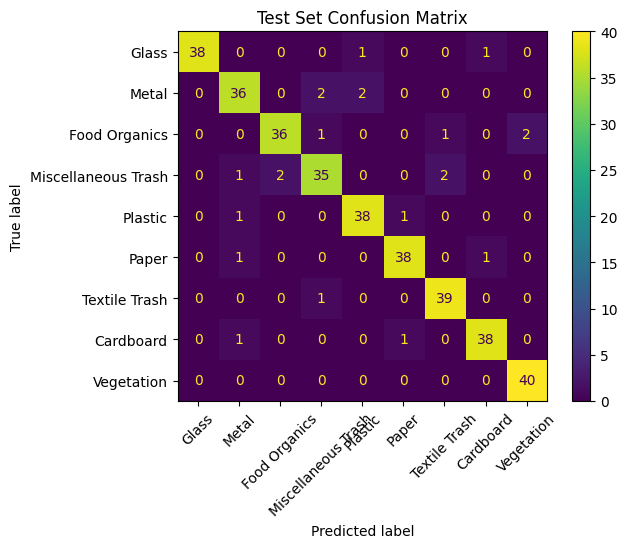

In [50]:
# 繪製混淆矩陣
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=all_classes)
disp.plot(xticks_rotation=45)
plt.title("Test Set Confusion Matrix")
plt.savefig(model_dir + "/confusion_matrix.png")
plt.show()


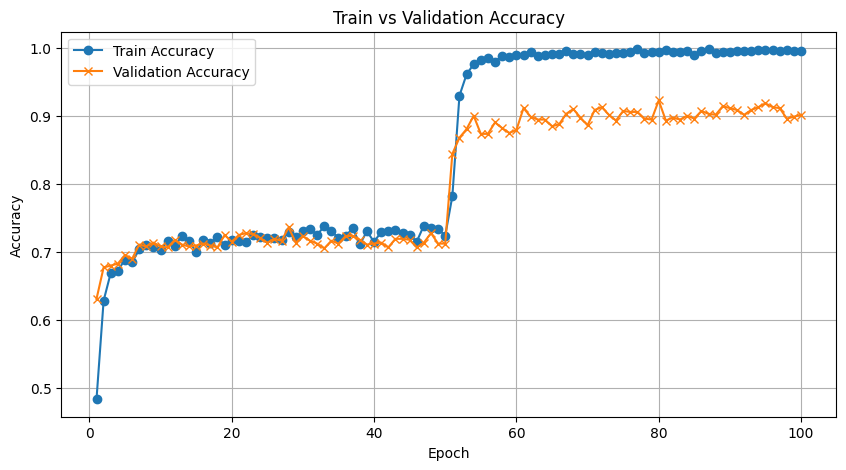

In [51]:

# 繪製 Train / Val Accuracy 曲線
epochs = list(range(1, initial_epochs + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_list, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_list, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(model_dir + "/accuracy_curve.png")
plt.show()
